# Get an Clean Tweets

Tutorial: https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/calculate-tweet-word-bigrams-networks-in-python/

In [1]:
!pip3 install seaborn

In [2]:
!pip3 install nltk

In [3]:
!pip3 install networkx

In [4]:
!pip3 install textblob

In [5]:
import datetime
import csv

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [6]:
#input your credentials here
consumer_key = 'EJ2bzIVQw7jSjJ5o0Cix6CzcS'
consumer_secret = 'd8aJEkFQLLyteH4mOjuxgtM3cKZNxPdCGivtWOUyaAvpmbPjQQ'
access_token = '1234205131807133696-GQVmr3bBV6bsUMDRPnnP1rpMNwBpXF'
access_token_secret = 'ynLMCC0V0y9AWJMo7md7YrWmIN63cSsYtomJJcgqrtDuA'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True)

In [7]:
# Create a custom search term and define the number of tweets
start_date = datetime.datetime(2020, 3, 28, 00, 00, 00)
end_date = datetime.datetime(2020, 4, 3, 00, 00, 00)

search_term = "#Coronavirus -filter:retweets"

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since=start_date,
                   until=end_date).items()

In [8]:
# Clean up
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    # remove words contains digits
    txt = ' '.join(s for s in txt.split() if not any(c.isdigit() for c in s))
    
    
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [9]:
# Remove URLs
tweets_no_urls = [remove_url(tweet.text) for tweet in tweets]

# Create a sublist of lower case words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]

In [10]:
tweets_no_urls[0]

'BloombergQuint Get ready CoronaLockdown Corona Markets open at and pre open is at Is it coronavirus'

In [11]:
# Download stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection words
collection_words = ['coronavirus', 'covid19', 'march', 'utc', 'est', 'pm', 'am', 'covid']

tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]
##[nltk_data] Downloading package stopwords to /root/nltk_data...
##[nltk_data]   Package stopwords is already up-to-date!

In [12]:
tweets_nsw_nc[0]

['bloombergquint',
 'get',
 'ready',
 'coronalockdown',
 'corona',
 'markets',
 'open',
 'pre',
 'open']

In [13]:
# Open/Create a file to append data
csvFile = open('28_3.csv', 'a')
#Use csv Writer
csvWriter = csv.writer(csvFile)

for tweet in tweets_nsw_nc:
    csvWriter.writerow(tweet)


# Analyze Word Frequency Counts

In [14]:
all_words_nsw = list(itertools.chain(*tweets_nsw_nc))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(30)

[('cases', 498),
 ('total', 204),
 ('deaths', 177),
 ('update', 176),
 ('new', 173),
 ('april', 132),
 ('us', 119),
 ('join', 106),
 ('recovered', 104),
 ('live', 103),
 ('confirmed', 99),
 ('today', 92),
 ('amp', 92),
 ('webinar', 85),
 ('iran', 84),
 ('briefing', 83),
 ('cet', 77),
 ('last', 62),
 ('fatalities', 58),
 ('time', 57),
 ('free', 56),
 ('press', 52),
 ('worldwide', 47),
 ('active', 46),
 ('task', 45),
 ('force', 45),
 ('gmt', 44),
 ('pandemic', 43),
 ('death', 43),
 ('people', 42)]

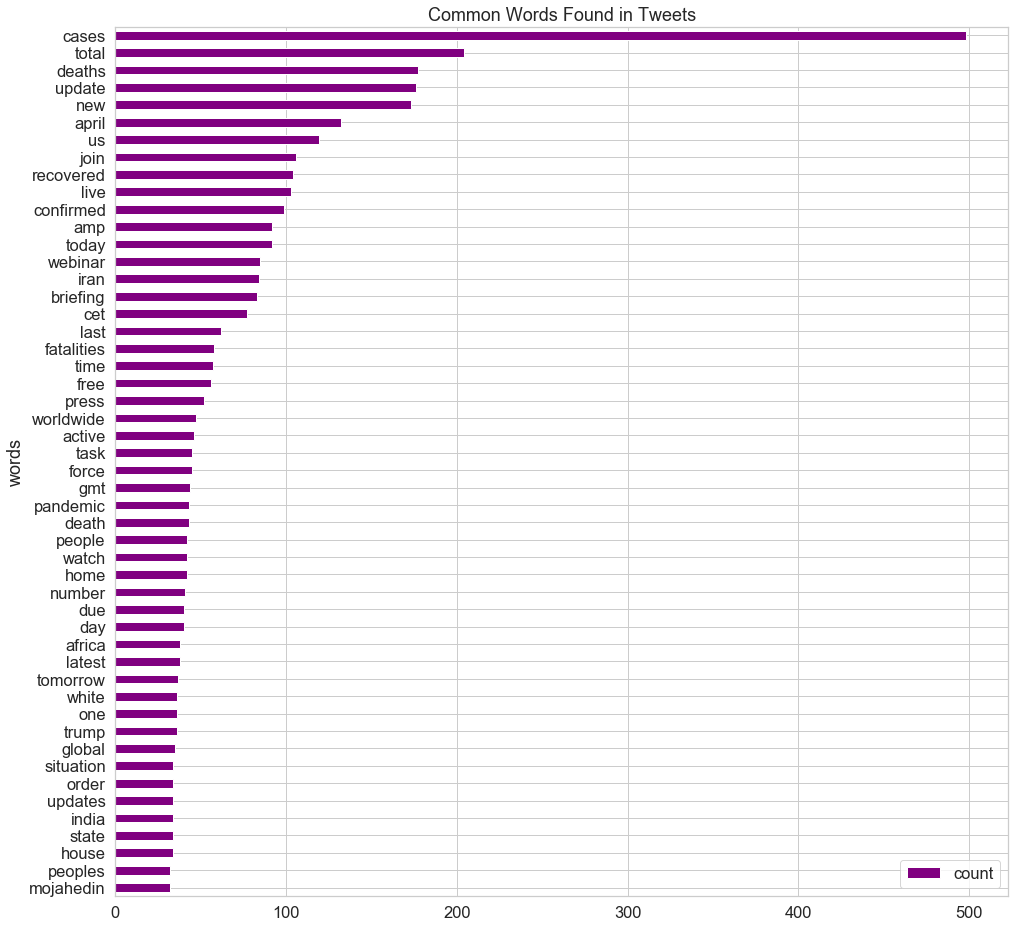

In [37]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(50),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(16, 16))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets")

plt.show()

# Explore Co-occurring Words (Bigrams)

In [16]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# View bigrams for the first tweet
terms_bigram[0]

[('bloombergquint', 'get'),
 ('get', 'ready'),
 ('ready', 'coronalockdown'),
 ('coronalockdown', 'corona'),
 ('corona', 'markets'),
 ('markets', 'open'),
 ('open', 'pre'),
 ('pre', 'open')]

In [17]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('new', 'cases'), 68),
 (('fatalities', 'cet'), 47),
 (('cases', 'deaths'), 46),
 (('confirmed', 'cases'), 45),
 (('join', 'us'), 43),
 (('task', 'force'), 42),
 (('total', 'cases'), 42),
 (('active', 'cases'), 42),
 (('press', 'briefing'), 40),
 (('total', 'confirmed'), 40),
 (('total', 'deaths'), 39),
 (('confirmed', 'total'), 37),
 (('deaths', 'recovered'), 37),
 (('deaths', 'last'), 34),
 (('white', 'house'), 34),
 (('iran', 'fatalities'), 34),
 (('total', 'recovered'), 33),
 (('last', 'update'), 33),
 (('recovered', 'total'), 32),
 (('peoples', 'mojahedin'), 32)]

In [18]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(new, cases)",68
1,"(fatalities, cet)",47
2,"(cases, deaths)",46
3,"(confirmed, cases)",45
4,"(join, us)",43
5,"(task, force)",42
6,"(total, cases)",42
7,"(active, cases)",42
8,"(press, briefing)",40
9,"(total, confirmed)",40


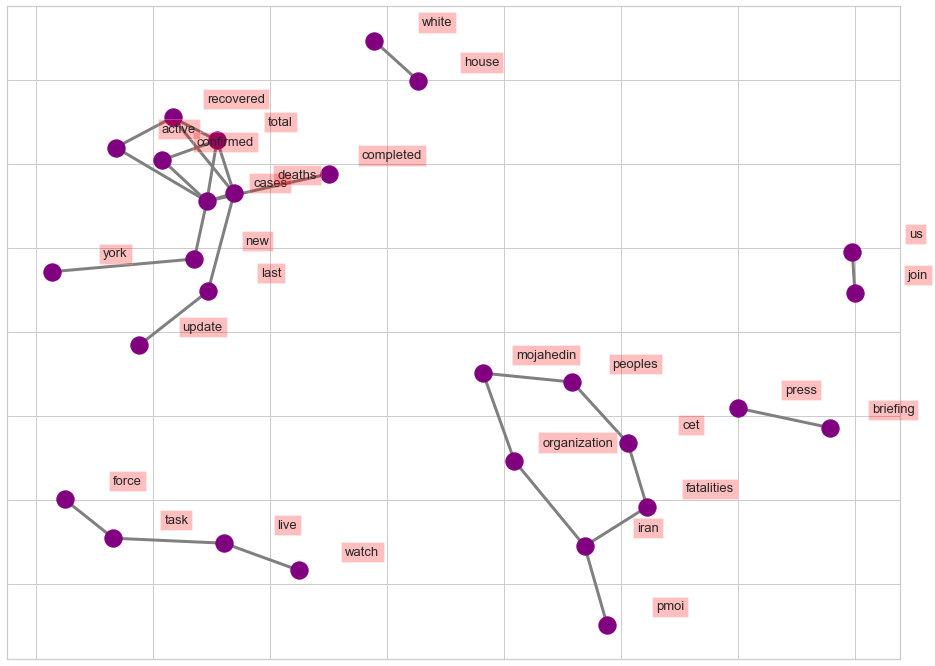

In [23]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 0.5))

fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

# Sentiment Analysis

In [24]:
sentiment_objects = [TextBlob(tweet) for tweet in tweets_no_urls]

In [25]:
sentiment_objects[0].polarity, sentiment_objects[0]

(0.06666666666666667,
 TextBlob("BloombergQuint Get ready CoronaLockdown Corona Markets open at and pre open is at Is it coronavirus"))

In [26]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [27]:
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

In [28]:
sentiment_df.head()

,polarity,tweet
0,0.066667,BloombergQuint Get ready CoronaLockdown Corona...
1,0.000000,To SIGN UP as a Volunteer to Assist Michigan i...
2,0.268182,The City of Lubbock says it has confirmed nine...
3,0.400000,The Wisconsin Democratic Primary has NOT been ...
4,0.600000,video Georgia Shelter In Place Executive Order...


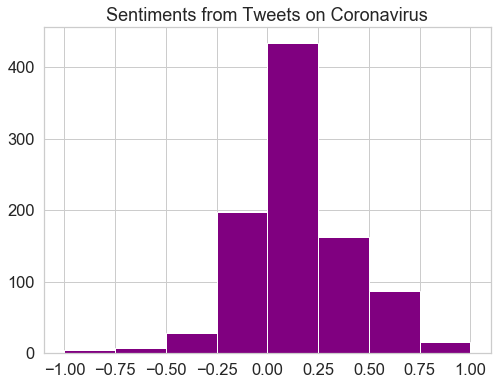

In [29]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Coronavirus")
plt.show()